In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Load the Data

In [2]:
# Load the data and inspect them
data = pd.read_csv('TSLA.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
1,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
2,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
3,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000
4,2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000


Successfully Read!
<br>Date: the date of each record
<br>Open: first traded price on each trading day
<br>High: highest price on each trading day
<br>Low: lowest price on each trading day
<br>Close: last price on each trading day
<br>Adj close: adjusted close price
<br>Volume: the number of stocks traded on each trading day

What should we do next?
We need to learn the regulations of the data to do prediction. Based on observation and business knowledge, we could find that if we would like to do prediction, we could predict the closing prices. Then, the time series conditions of the closing price will be shown in the plot below.

<Axes: xlabel='Date'>

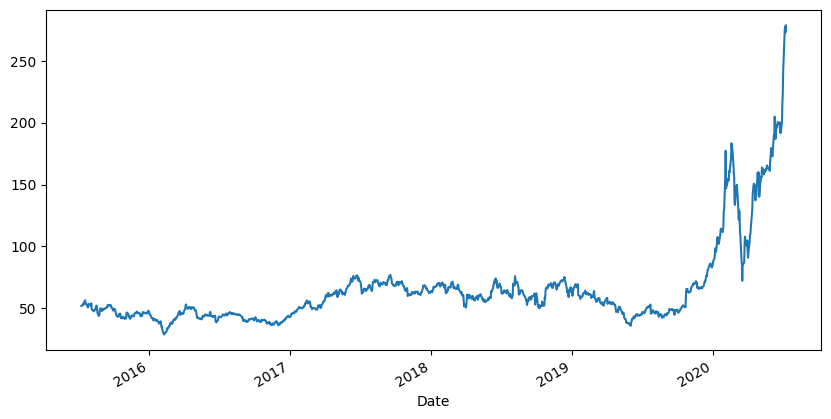

In [3]:
#visualization the stock price without lag
data= data[['Date', 'Close']]
data.Date = pd.to_datetime(data.Date, format = '%Y/%m/%d')
plot = data.set_index('Date')

plot['Close'].plot(figsize=(10,5))

In [4]:
#we will continue working with the closing price(delete the date)
data_drop=data.drop(["Date"],axis=1)
data_new=data_drop.values

In [5]:
print(data_new)

[[ 51.830002]
 [ 52.431999]
 [ 53.130001]
 ...
 [277.971985]
 [273.175995]
 [278.855988]]


In [6]:
data_new.shape

(1259, 1)

In [7]:
#normalized the data
scaler = MinMaxScaler(feature_range = (0, 1))
data_normalized = scaler.fit_transform(data_new)

# Split the data

In [8]:
#split the data into training and test sets
#set that training data is about 80%, test is about 20% (as normal setting)
training_size = int(len(data_normalized) * 0.8)
test_size= len(data_normalized)-training_size

train = data_normalized[0:training_size, :]
test = data_normalized[training_size:len(data_normalized), :]

In [9]:
print(training_size)
print(test_size)
train.shape, test.shape

1007
252


((1007, 1), (252, 1))

#One-day time lag

In [10]:
#build the input features with different time lags
def input_features(data, lag):
    X, Y = [], []
    for i in range(len(data) -lag):
        X.append(data[i:(i+1), 0])
        Y.append(data[i + lag, 0])
    return np.array(X), np.array(Y)

In [11]:
lag=1

In [12]:
#The closing price of the last day could predict the price of today;
#the price of today could predict the price of tomorrow.
X_train, Y_train = input_features(train, lag)
X_test, Y_test = input_features(test, lag)

#Reshape to the format of [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_train.shape,X_test.shape, Y_train.shape, Y_test.shape

((1006, 1, 1), (251, 1, 1), (1006,), (251,))

In [13]:
#create the LSTM model
def lstm(lstm_layer=6):
  model = Sequential()

  model.add(LSTM(units = 50, activation = 'relu', return_sequences=True,
                 input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))

  for layer in range(lstm_layer-1):
    model.add(LSTM(50, return_sequences= False))
    model.add(Dropout(0.2))

    model.add(Dense(1))

    return model

for lstm_layer in [4,5,6]:
  model=lstm(lstm_layer)

In [14]:
#change another drop rate
def lstm2(lstm_layer=4):
  model = Sequential()

  model.add(LSTM(units = 50, activation = 'relu', return_sequences=True,
                 input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.3))

  for layer in range(lstm_layer-1):
    model.add(LSTM(50, return_sequences= False))
    model.add(Dropout(0.3))

    model.add(Dense(1))

    return model

for lstm_layer in [4,5,6]:
  model=lstm2(lstm_layer)

In [15]:
models={'drop_0.2_4_h_layer': lstm(4),'drop_0.2_5_h_layer': lstm(5), 'drop_0.2_6_h_layer': lstm(6),
        'drop_0.3_4_h_layer': lstm2(4),'drop_0.3_5_h_layer': lstm2(5), 'drop_0.3_6_h_layer': lstm2(6)}

In [16]:
histories={}

for name, model in models.items():
  model.compile(optimizer = 'adam', loss = 'mse' , metrics="mean_absolute_error")

  history = model.fit(X_train, Y_train, epochs = 100, batch_size = 20, validation_data = (X_test, Y_test), verbose = 1, shuffle = False)

  histories[name]=history

Epoch 1/100
51/51 [==============================] - 10s 37ms/step - loss: 0.0027 - mean_absolute_error: 0.0421 - val_loss: 0.0643 - val_mean_absolute_error: 0.1848
Epoch 2/100
51/51 [==============================] - 1s 11ms/step - loss: 0.0033 - mean_absolute_error: 0.0498 - val_loss: 0.0684 - val_mean_absolute_error: 0.1901
Epoch 3/100
51/51 [==============================] - 0s 9ms/step - loss: 0.0029 - mean_absolute_error: 0.0471 - val_loss: 0.0661 - val_mean_absolute_error: 0.1868
Epoch 4/100
51/51 [==============================] - 0s 10ms/step - loss: 0.0028 - mean_absolute_error: 0.0465 - val_loss: 0.0640 - val_mean_absolute_error: 0.1839
Epoch 5/100
51/51 [==============================] - 0s 8ms/step - loss: 0.0027 - mean_absolute_error: 0.0456 - val_loss: 0.0608 - val_mean_absolute_error: 0.1793
Epoch 6/100
51/51 [==============================] - 0s 8ms/step - loss: 0.0026 - mean_absolute_error: 0.0448 - val_loss: 0.0571 - val_mean_absolute_error: 0.1738
Epoch 7/100
51/51 

In [17]:
def plot_loss(train_loss, val_loss, Title):
    x = [i for i in range(0, len(val_loss))]
    y= train_loss
    plt.plot(x,y, color="blue")

    x = [i for i in range(0, len(val_loss))]
    y= val_loss
    plt.plot(x,y, color="yellow")

    plt.ylabel('Losses')
    plt.xlabel('Epoches')
    plt.legend(['training loss','validation loss'])
    plt.ylim(ymax=0.10,ymin=0)
    plt.xlim(xmax=100,xmin=0)
    plt.grid(True)
    plt.show()

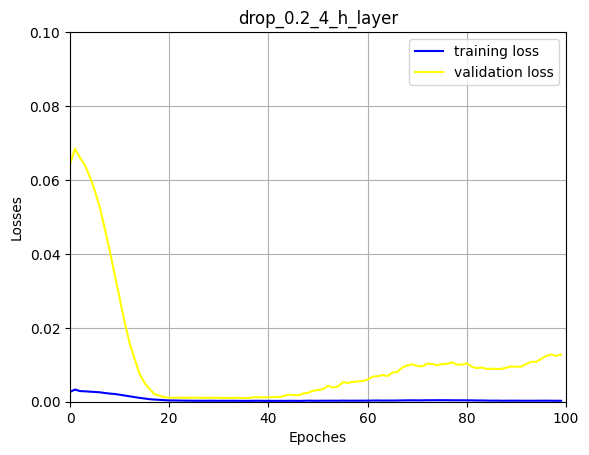

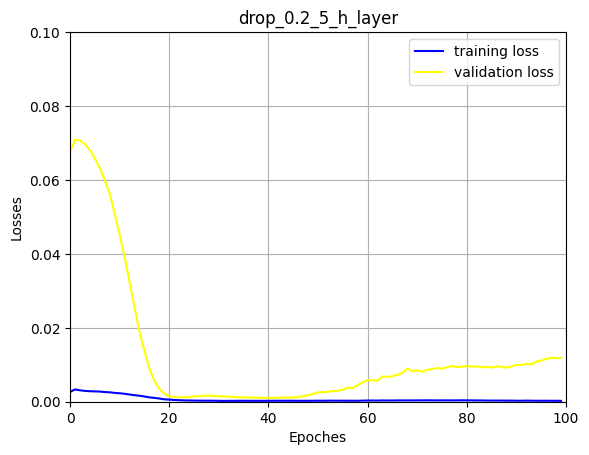

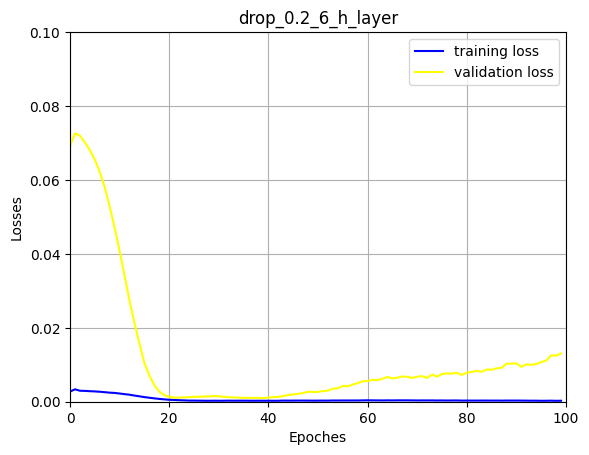

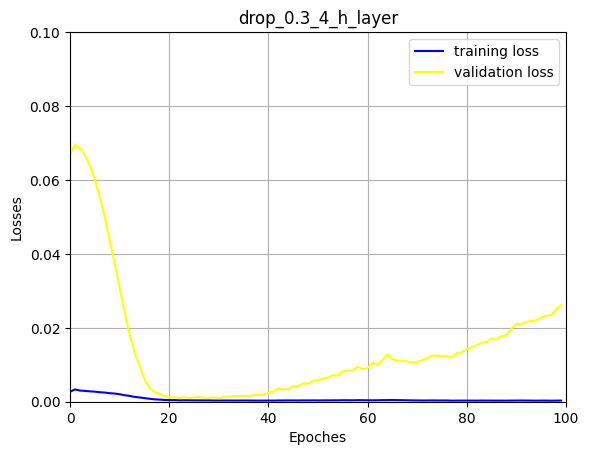

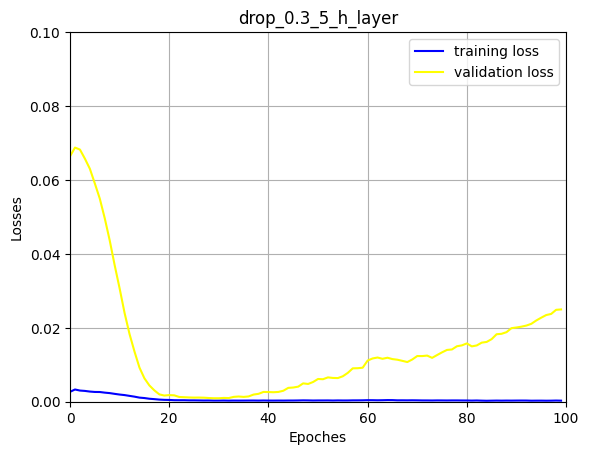

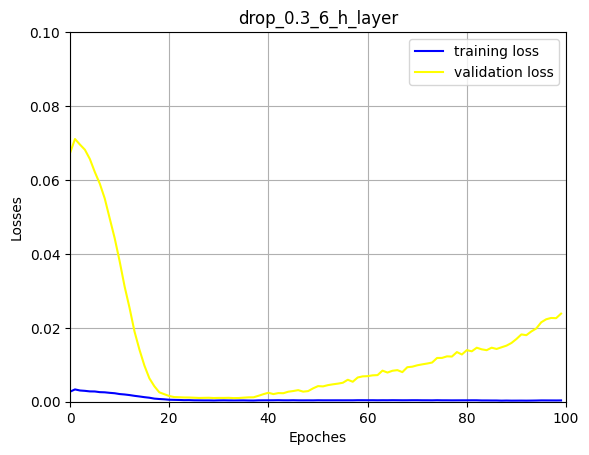

In [18]:
for name, history in histories.items():
  plt.title(name)
  plot_loss(history.history['loss'],history.history['val_loss'], "Loss")

After comparing all the plots, we could find that the model "drop out rate=0.2, hidden layer=4" is the best, when the epoch=25, so that we will use the result to do prediction in the following step. TBH, there is not great differences in the time lag=1, so that we might have other model options, while there will be great differences when time lage is higher.

In [19]:
model=lstm(lstm_layer=4)
  #lstm() is the model dropping out rate is 0.2, lstm2() is the rate of 0.3;
  #also, lstm_layer=4, that's the number of hidden layers, 4

In [20]:
model.compile(optimizer = 'adam', loss = 'mse' , metrics="mean_absolute_error")

history = model.fit(X_train, Y_train, epochs = 25, batch_size = 20, validation_data = (X_test, Y_test), verbose = 1, shuffle = False) #select epoch=25 here

Epoch 1/25
51/51 [==============================] - 5s 16ms/step - loss: 0.0028 - mean_absolute_error: 0.0430 - val_loss: 0.0670 - val_mean_absolute_error: 0.1887
Epoch 2/25
51/51 [==============================] - 0s 4ms/step - loss: 0.0033 - mean_absolute_error: 0.0501 - val_loss: 0.0709 - val_mean_absolute_error: 0.1935
Epoch 3/25
51/51 [==============================] - 0s 5ms/step - loss: 0.0029 - mean_absolute_error: 0.0474 - val_loss: 0.0687 - val_mean_absolute_error: 0.1905
Epoch 4/25
51/51 [==============================] - 0s 5ms/step - loss: 0.0029 - mean_absolute_error: 0.0469 - val_loss: 0.0662 - val_mean_absolute_error: 0.1870
Epoch 5/25
51/51 [==============================] - 0s 4ms/step - loss: 0.0028 - mean_absolute_error: 0.0463 - val_loss: 0.0629 - val_mean_absolute_error: 0.1823
Epoch 6/25
51/51 [==============================] - 0s 4ms/step - loss: 0.0027 - mean_absolute_error: 0.0454 - val_loss: 0.0589 - val_mean_absolute_error: 0.1765
Epoch 7/25
51/51 [=========

In [21]:
#prediction
Y_prediction = model.predict(X_test)
Y_prediction = scaler.inverse_transform(Y_prediction)

8/8 [==============================] - 1s 2ms/step


In [22]:
Y_prediction.shape

(251, 1)

In [23]:
train_df = data.iloc[:training_size , :]
train_df.Date = pd.to_datetime(train_df.Date, format = '%Y/%m/%d')
test_df = data.iloc[training_size: , :]
test_df.Date = pd.to_datetime(test_df.Date, format = '%Y/%m/%d')

<ipython-input-23-4ef475970526>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.Date = pd.to_datetime(train_df.Date, format = '%Y/%m/%d')
<ipython-input-23-4ef475970526>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.Date = pd.to_datetime(test_df.Date, format = '%Y/%m/%d')


In [24]:
test_df.shape

(252, 2)

In [25]:
test_df['Prediction'] = np.nan # Initialize new column 'Prediction' with NaN values

test_df.iloc[lag:, 2] = Y_prediction

<ipython-input-25-e78d812fd9ed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Prediction'] = np.nan # Initialize new column 'Prediction' with NaN values


In [26]:
test_df.head() #that's normal that there is always one data gap between the number of rocrds in the test set and that of prediction, because the time lag =1(More detailed explanation shown in the slides)
#Similarlity, there will be always 5 more records when time lag=5, 10 more when time lag=10, which I will show in the head(5) or head(10) commend later.

,Date,Close,Prediction
1007,2019-07-11,47.720001,NaN
1008,2019-07-12,49.015999,49.011860
1009,2019-07-15,50.700001,50.049522
1010,2019-07-16,50.476002,51.406189
1011,2019-07-17,50.972000,51.225189


<Axes: xlabel='Date'>

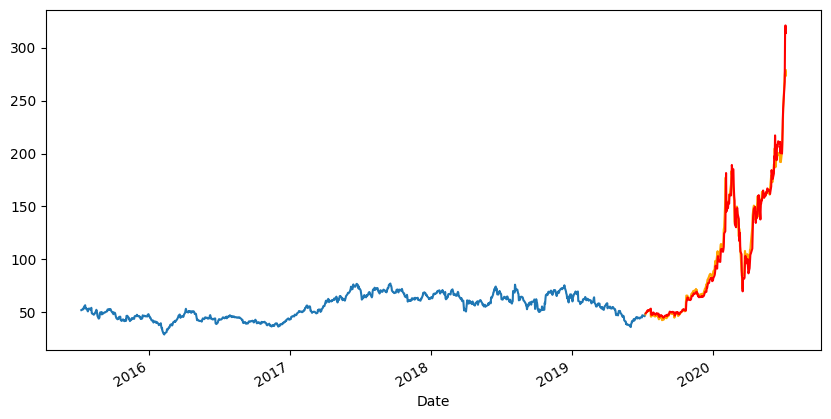

In [27]:
plot = train_df.set_index('Date')
plot2 = test_df.set_index('Date')


plot['Close'].plot(figsize=(10,5))

plot2['Close'].plot(figsize=(10,5), color="orange")
plot2['Prediction'].plot(figsize=(10,5),color="red") #orange line is the test set, red line is the prediction

#Five-day time lag (updated)

In [28]:
#build the input features with different time lags
def input_features(data, lag):
    X, Y = [], []
    for i in range(len(data) -lag):
        X.append(data[i:(i+1), 0]) #change here compared with the updated version uploaded this Monday
        Y.append(data[i + lag, 0])
    return np.array(X), np.array(Y)

In [29]:
lag=5

In [30]:
#The closing price of the last day could predict the price of today;
#the price of today could predict the price of tomorrow.
X_train, Y_train = input_features(train, lag)
X_test, Y_test = input_features(test, lag)

#Reshape to the format of [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_train.shape,X_test.shape, Y_train.shape, Y_test.shape

((1002, 1, 1), (247, 1, 1), (1002,), (247,))

In [31]:
#create the LSTM model
def lstm(lstm_layer=6):
  model = Sequential()

  model.add(LSTM(units = 50, activation = 'relu', return_sequences=True,
                 input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))

  for layer in range(lstm_layer-1):
    model.add(LSTM(50, return_sequences= False))
    model.add(Dropout(0.2))

    model.add(Dense(1))

    return model

for lstm_layer in [4,5,6]:
  model=lstm(lstm_layer)

In [32]:
#change another drop rate
def lstm2(lstm_layer=4):
  model = Sequential()

  model.add(LSTM(units = 50, activation = 'relu', return_sequences=True,
                 input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.3))

  for layer in range(lstm_layer-1):
    model.add(LSTM(50, return_sequences= False))
    model.add(Dropout(0.3))

    model.add(Dense(1))

    return model

for lstm_layer in [4,5,6]:
  model=lstm2(lstm_layer)

In [33]:
models={'drop_0.2_4_h_layer': lstm(4),'drop_0.2_5_h_layer': lstm(5), 'drop_0.2_6_h_layer': lstm(6),
        'drop_0.3_4_h_layer': lstm2(4),'drop_0.3_5_h_layer': lstm2(5), 'drop_0.3_6_h_layer': lstm2(6)} #Because there was not great difference in time lag=1, we will do model selection again here in time lag=5

In [34]:
histories={}

for name, model in models.items():
  model.compile(optimizer = 'adam', loss = 'mse' , metrics="mean_absolute_error")

  history = model.fit(X_train, Y_train, epochs = 100, batch_size = 20, validation_data = (X_test, Y_test), verbose = 1, shuffle = False)

  histories[name]=history

Epoch 1/100
51/51 [==============================] - 4s 17ms/step - loss: 0.0026 - mean_absolute_error: 0.0413 - val_loss: 0.0666 - val_mean_absolute_error: 0.1883
Epoch 2/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0033 - mean_absolute_error: 0.0489 - val_loss: 0.0684 - val_mean_absolute_error: 0.1905
Epoch 3/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0030 - mean_absolute_error: 0.0481 - val_loss: 0.0669 - val_mean_absolute_error: 0.1883
Epoch 4/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0029 - mean_absolute_error: 0.0467 - val_loss: 0.0653 - val_mean_absolute_error: 0.1859
Epoch 5/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0027 - mean_absolute_error: 0.0454 - val_loss: 0.0626 - val_mean_absolute_error: 0.1819
Epoch 6/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0026 - mean_absolute_error: 0.0446 - val_loss: 0.0587 - val_mean_absolute_error: 0.1761
Epoch 7/100
51/51 [==

In [35]:
def plot_loss(train_loss, val_loss, Title):
    x = [i for i in range(0, len(val_loss))]
    y= train_loss
    plt.plot(x,y, color="blue")

    x = [i for i in range(0, len(val_loss))]
    y= val_loss
    plt.plot(x,y, color="yellow")

    plt.ylabel('Losses')
    plt.xlabel('Epoches')
    plt.legend(['training loss','validation loss'])
    plt.ylim(ymax=0.10,ymin=0)
    plt.xlim(xmax=100,xmin=0)
    plt.grid(True)
    plt.show()

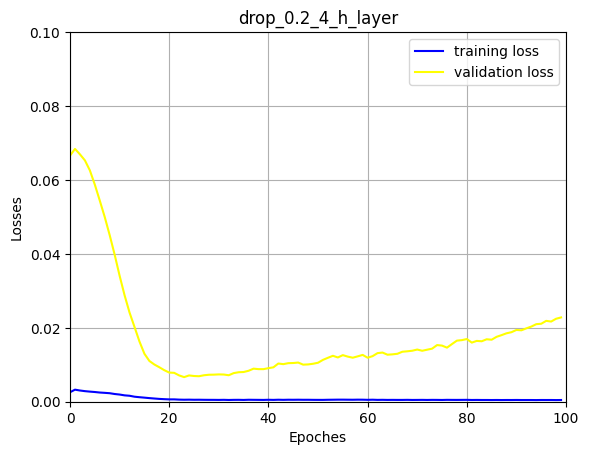

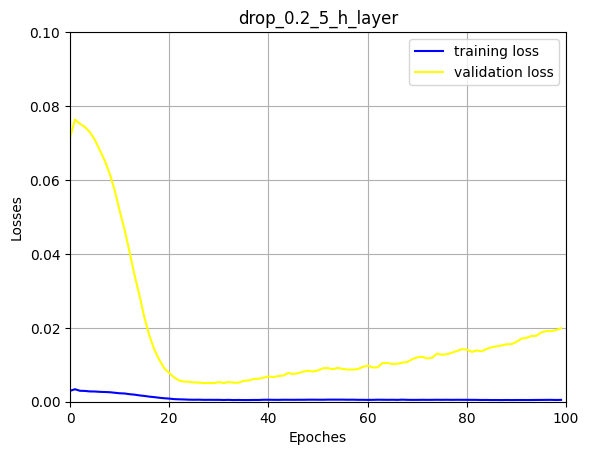

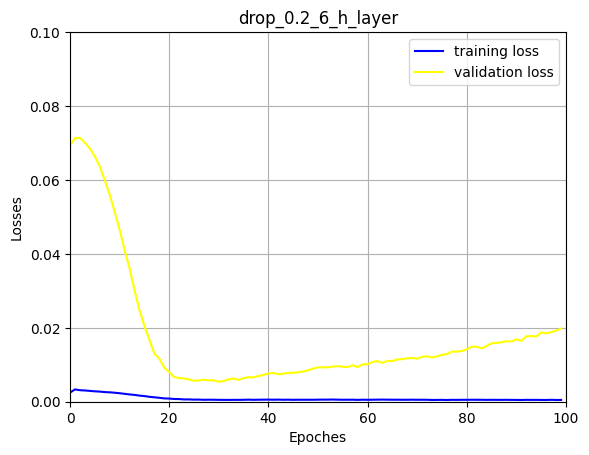

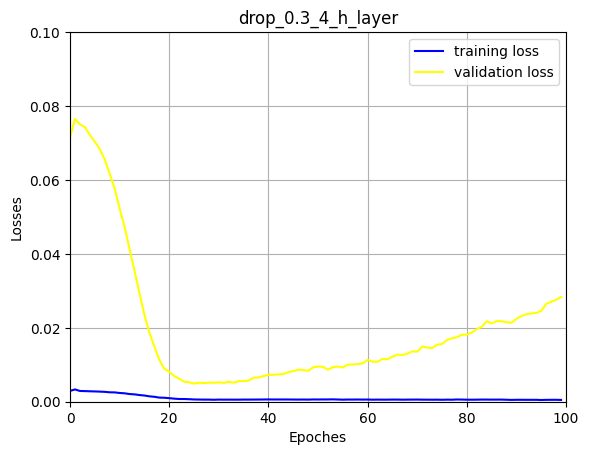

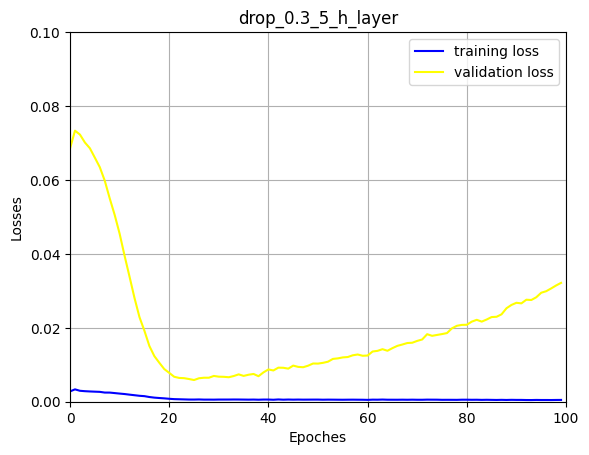

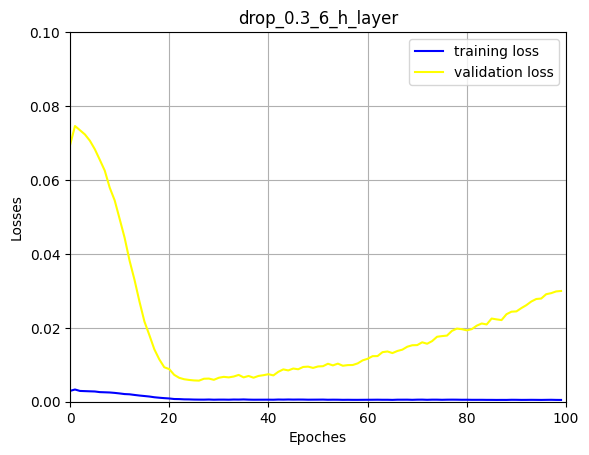

In [36]:
for name, history in histories.items():
  plt.title(name)
  plot_loss(history.history['loss'],history.history['val_loss'], "Loss")

Unlike time lag=1, in the time lag=5, we could find the great differences in the 6 models above, so we could say that the model "drop out rate=0.2, hidden layer=4" is the best, when the epoch=25, so that we will use the result to do prediction in the following step.

In [37]:
model=lstm(lstm_layer=4)
  #lstm() is the model dropping out rate is 0.2, lstm2() is the rate of 0.3;
  #also, lstm_layer=6, that's the number of hidden layers, 4

In [38]:
model.compile(optimizer = 'adam', loss = 'mse' , metrics="mean_absolute_error")

history = model.fit(X_train, Y_train, epochs = 25, batch_size = 20, validation_data = (X_test, Y_test), verbose = 1, shuffle = False) #select epoch=25 here

Epoch 1/25
51/51 [==============================] - 5s 19ms/step - loss: 0.0028 - mean_absolute_error: 0.0432 - val_loss: 0.0680 - val_mean_absolute_error: 0.1904
Epoch 2/25
51/51 [==============================] - 0s 5ms/step - loss: 0.0033 - mean_absolute_error: 0.0497 - val_loss: 0.0721 - val_mean_absolute_error: 0.1957
Epoch 3/25
51/51 [==============================] - 0s 5ms/step - loss: 0.0029 - mean_absolute_error: 0.0473 - val_loss: 0.0702 - val_mean_absolute_error: 0.1930
Epoch 4/25
51/51 [==============================] - 0s 5ms/step - loss: 0.0028 - mean_absolute_error: 0.0467 - val_loss: 0.0682 - val_mean_absolute_error: 0.1902
Epoch 5/25
51/51 [==============================] - 0s 5ms/step - loss: 0.0027 - mean_absolute_error: 0.0459 - val_loss: 0.0651 - val_mean_absolute_error: 0.1857
Epoch 6/25
51/51 [==============================] - 0s 4ms/step - loss: 0.0026 - mean_absolute_error: 0.0449 - val_loss: 0.0617 - val_mean_absolute_error: 0.1806
Epoch 7/25
51/51 [=========

In [39]:
#prediction
Y_prediction = model.predict(X_test)
Y_prediction = scaler.inverse_transform(Y_prediction)

8/8 [==============================] - 1s 2ms/step


In [40]:
Y_prediction.shape

(247, 1)

In [41]:
train_df = data.iloc[:training_size , :]
train_df.Date = pd.to_datetime(train_df.Date, format = '%Y/%m/%d')
test_df = data.iloc[training_size: , :]
test_df.Date = pd.to_datetime(test_df.Date, format = '%Y/%m/%d')

<ipython-input-41-4ef475970526>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.Date = pd.to_datetime(train_df.Date, format = '%Y/%m/%d')
<ipython-input-41-4ef475970526>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.Date = pd.to_datetime(test_df.Date, format = '%Y/%m/%d')


In [42]:
test_df.shape

(252, 2)

In [43]:
test_df['Prediction'] = np.nan # Initialize new column 'Prediction' with NaN values

test_df.iloc[lag:, 2] = Y_prediction

<ipython-input-43-e78d812fd9ed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Prediction'] = np.nan # Initialize new column 'Prediction' with NaN values


In [44]:
test_df.head(10)

,Date,Close,Prediction
1007,2019-07-11,47.720001,NaN
1008,2019-07-12,49.015999,NaN
1009,2019-07-15,50.700001,NaN
1010,2019-07-16,50.476002,NaN
1011,2019-07-17,50.972000,NaN
1012,2019-07-18,50.708000,49.960350
1013,2019-07-19,51.636002,50.907902
1014,2019-07-22,51.136002,52.147751
1015,2019-07-23,52.034000,51.982368
1016,2019-07-24,52.976002,52.348759


<Axes: xlabel='Date'>

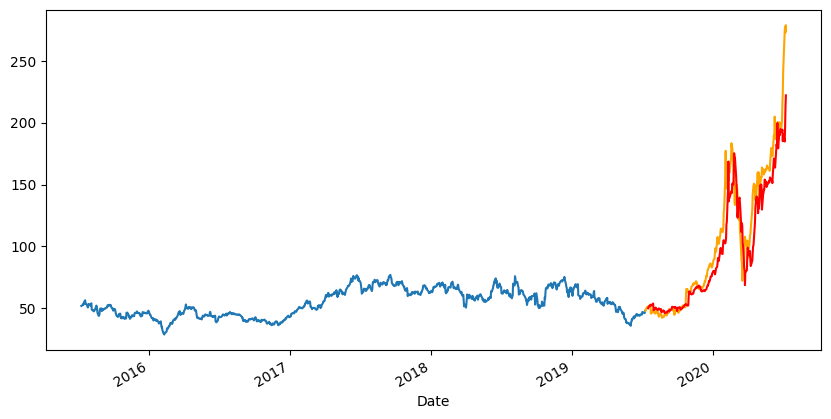

In [45]:
plot = train_df.set_index('Date')
plot2 = test_df.set_index('Date')


plot['Close'].plot(figsize=(10,5))

plot2['Close'].plot(figsize=(10,5), color="orange")
plot2['Prediction'].plot(figsize=(10,5),color="red") #orange line is the test set, red line is the prediction

#Ten-day time lag (updated)

In [46]:
#build the input features with different time lags
def input_features(data, lag):
    X, Y = [], []
    for i in range(len(data) -lag):
        X.append(data[i:(i+1), 0]) #change here compared with the updated version uploaded this Monday
        Y.append(data[i + lag, 0])
    return np.array(X), np.array(Y)

In [47]:
lag=10

In [48]:
#The closing price of the last day could predict the price of today;
#the price of today could predict the price of tomorrow.
X_train, Y_train = input_features(train, lag)
X_test, Y_test = input_features(test, lag)

#Reshape to the format of [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_train.shape,X_test.shape, Y_train.shape, Y_test.shape

((997, 1, 1), (242, 1, 1), (997,), (242,))

In [49]:
#create the LSTM model
def lstm(lstm_layer=6):
  model = Sequential()

  model.add(LSTM(units = 50, activation = 'relu', return_sequences=True,
                 input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))

  for layer in range(lstm_layer-1):
    model.add(LSTM(50, return_sequences= False))
    model.add(Dropout(0.2))

    model.add(Dense(1))

    return model

for lstm_layer in [4,5,6]:
  model=lstm(lstm_layer)

In [50]:
#change another drop rate
def lstm2(lstm_layer=4):
  model = Sequential()

  model.add(LSTM(units = 50, activation = 'relu', return_sequences=True,
                 input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.3))

  for layer in range(lstm_layer-1):
    model.add(LSTM(50, return_sequences= False))
    model.add(Dropout(0.3))

    model.add(Dense(1))

    return model

for lstm_layer in [4,5,6]:
  model=lstm2(lstm_layer)

In [51]:
models={'drop_0.2_4_h_layer': lstm(4),'drop_0.2_5_h_layer': lstm(5), 'drop_0.2_6_h_layer': lstm(6),
        'drop_0.3_4_h_layer': lstm2(4),'drop_0.3_5_h_layer': lstm2(5), 'drop_0.3_6_h_layer': lstm2(6)} #Because there was not great difference in time lag=1, we will do model selection again here in time lag=6

In [52]:
histories={}

for name, model in models.items():
  model.compile(optimizer = 'adam', loss = 'mse' , metrics="mean_absolute_error")

  history = model.fit(X_train, Y_train, epochs = 100, batch_size = 20, validation_data = (X_test, Y_test), verbose = 1, shuffle = False)

  histories[name]=history

Epoch 1/100
50/50 [==============================] - 4s 16ms/step - loss: 0.0027 - mean_absolute_error: 0.0425 - val_loss: 0.0707 - val_mean_absolute_error: 0.1952
Epoch 2/100
50/50 [==============================] - 0s 5ms/step - loss: 0.0035 - mean_absolute_error: 0.0517 - val_loss: 0.0766 - val_mean_absolute_error: 0.2030
Epoch 3/100
50/50 [==============================] - 0s 4ms/step - loss: 0.0030 - mean_absolute_error: 0.0481 - val_loss: 0.0754 - val_mean_absolute_error: 0.2014
Epoch 4/100
50/50 [==============================] - 0s 4ms/step - loss: 0.0030 - mean_absolute_error: 0.0478 - val_loss: 0.0744 - val_mean_absolute_error: 0.1999
Epoch 5/100
50/50 [==============================] - 0s 5ms/step - loss: 0.0029 - mean_absolute_error: 0.0471 - val_loss: 0.0729 - val_mean_absolute_error: 0.1978
Epoch 6/100
50/50 [==============================] - 0s 5ms/step - loss: 0.0028 - mean_absolute_error: 0.0469 - val_loss: 0.0711 - val_mean_absolute_error: 0.1953
Epoch 7/100
50/50 [==

In [53]:
def plot_loss(train_loss, val_loss, Title):
    x = [i for i in range(0, len(val_loss))]
    y= train_loss
    plt.plot(x,y, color="blue")

    x = [i for i in range(0, len(val_loss))]
    y= val_loss
    plt.plot(x,y, color="yellow")

    plt.ylabel('Losses')
    plt.xlabel('Epoches')
    plt.legend(['training loss','validation loss'])
    plt.ylim(ymax=0.10,ymin=0)
    plt.xlim(xmax=100,xmin=0)
    plt.grid(True)
    plt.show()

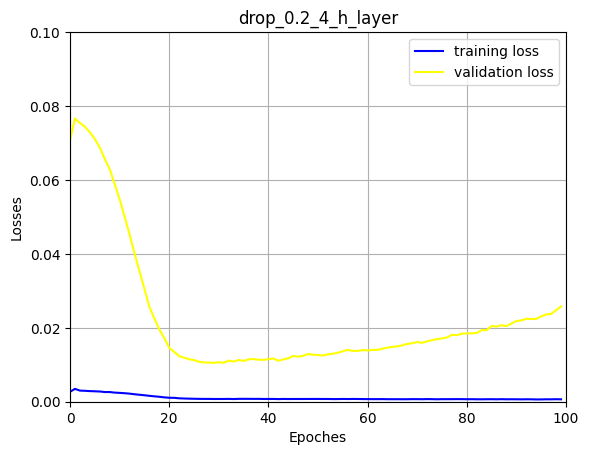

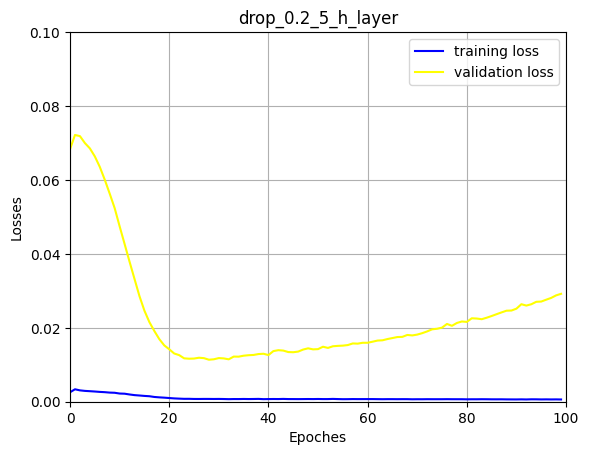

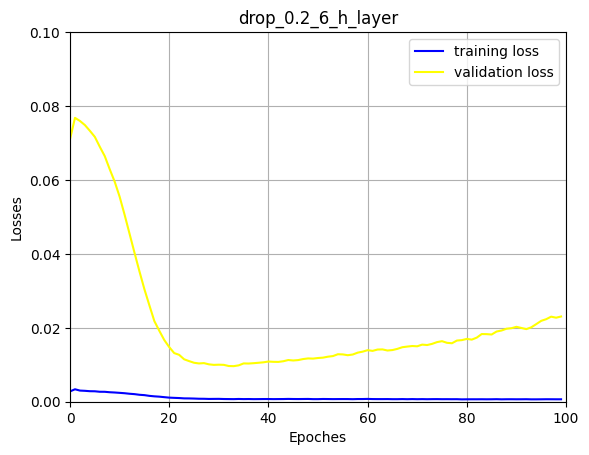

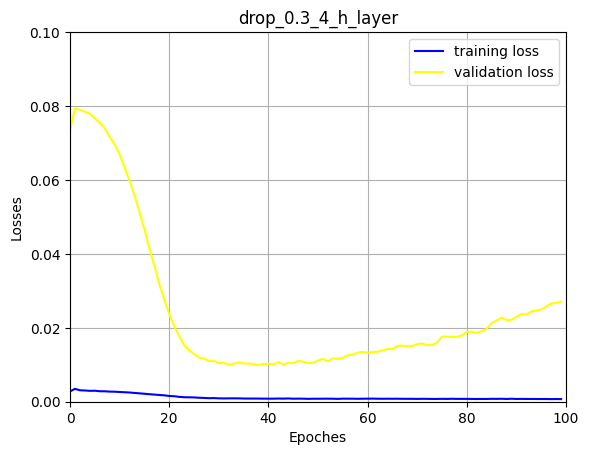

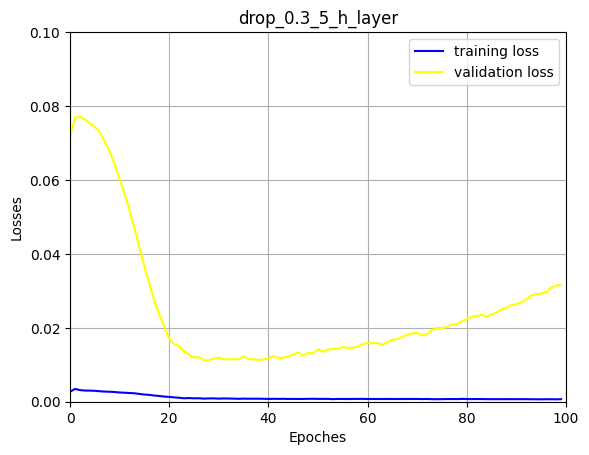

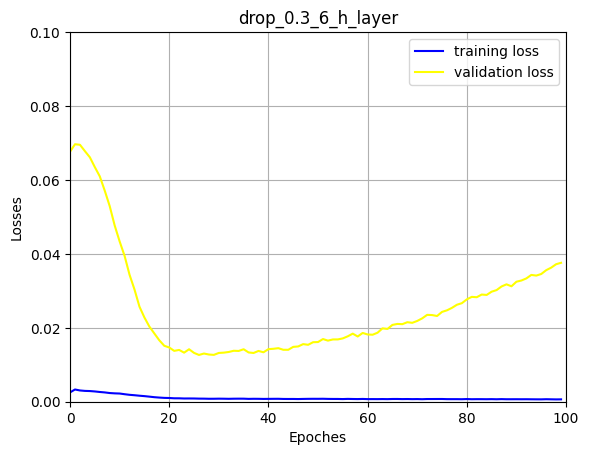

In [54]:
for name, history in histories.items():
  plt.title(name)
  plot_loss(history.history['loss'],history.history['val_loss'], "Loss")

Okat so, for time lag=10, we could find the great differences in the 6 models above, so we could say that the model "drop out rate=0.2, hidden layer=4" is the best, when the epoch=30, so that we will use the result to do prediction in the following step.

In [55]:
model=lstm(lstm_layer=4)
  #lstm() is the model dropping out rate is 0.2, lstm2() is the rate of 0.3;
  #also, lstm_layer=4, that's the number of hidden layers, 4

In [56]:
model.compile(optimizer = 'adam', loss = 'mse' , metrics="mean_absolute_error")

history = model.fit(X_train, Y_train, epochs = 30, batch_size = 20, validation_data = (X_test, Y_test), verbose = 1, shuffle = False) #select epoch=30 here

Epoch 1/30
50/50 [==============================] - 5s 39ms/step - loss: 0.0031 - mean_absolute_error: 0.0460 - val_loss: 0.0736 - val_mean_absolute_error: 0.1992
Epoch 2/30
50/50 [==============================] - 0s 7ms/step - loss: 0.0033 - mean_absolute_error: 0.0510 - val_loss: 0.0790 - val_mean_absolute_error: 0.2063
Epoch 3/30
50/50 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_absolute_error: 0.0478 - val_loss: 0.0773 - val_mean_absolute_error: 0.2039
Epoch 4/30
50/50 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_absolute_error: 0.0476 - val_loss: 0.0768 - val_mean_absolute_error: 0.2032
Epoch 5/30
50/50 [==============================] - 0s 7ms/step - loss: 0.0028 - mean_absolute_error: 0.0469 - val_loss: 0.0741 - val_mean_absolute_error: 0.1996
Epoch 6/30
50/50 [==============================] - 0s 7ms/step - loss: 0.0028 - mean_absolute_error: 0.0467 - val_loss: 0.0727 - val_mean_absolute_error: 0.1975
Epoch 7/30
50/50 [=========

In [57]:
#prediction
Y_prediction = model.predict(X_test)
Y_prediction = scaler.inverse_transform(Y_prediction)

8/8 [==============================] - 1s 3ms/step


In [58]:
Y_prediction.shape

(242, 1)

In [59]:
train_df = data.iloc[:training_size , :]
train_df.Date = pd.to_datetime(train_df.Date, format = '%Y/%m/%d')
test_df = data.iloc[training_size: , :]
test_df.Date = pd.to_datetime(test_df.Date, format = '%Y/%m/%d')

<ipython-input-59-4ef475970526>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.Date = pd.to_datetime(train_df.Date, format = '%Y/%m/%d')
<ipython-input-59-4ef475970526>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.Date = pd.to_datetime(test_df.Date, format = '%Y/%m/%d')


In [60]:
test_df.shape

(252, 2)

In [61]:
test_df['Prediction'] = np.nan # Initialize new column 'Prediction' with NaN values

test_df.iloc[lag:, 2] = Y_prediction

<ipython-input-61-e78d812fd9ed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Prediction'] = np.nan # Initialize new column 'Prediction' with NaN values


In [62]:
test_df.head(15)

,Date,Close,Prediction
1007,2019-07-11,47.720001,NaN
1008,2019-07-12,49.015999,NaN
1009,2019-07-15,50.700001,NaN
1010,2019-07-16,50.476002,NaN
1011,2019-07-17,50.972000,NaN
1012,2019-07-18,50.708000,NaN
1013,2019-07-19,51.636002,NaN
1014,2019-07-22,51.136002,NaN
1015,2019-07-23,52.034000,NaN
1016,2019-07-24,52.976002,NaN


<Axes: xlabel='Date'>

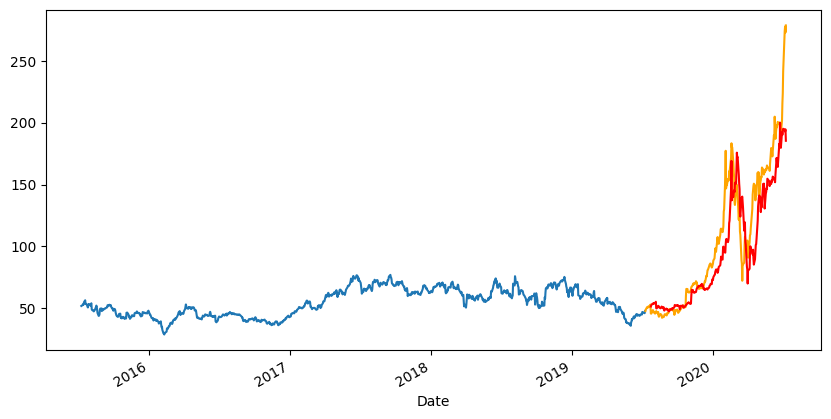

In [63]:
plot = train_df.set_index('Date')
plot2 = test_df.set_index('Date')


plot['Close'].plot(figsize=(10,5))

plot2['Close'].plot(figsize=(10,5), color="orange")
plot2['Prediction'].plot(figsize=(10,5),color="red") #orange line is the test set, red line is the prediction